This script is used for training a HD-CNN.
Zhicheng "Stephen" Yan, 2015

In [1]:
import os
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.linalg
from sklearn.cluster import k_means
from sklearn.cluster import *
import copy
import leveldb
import lmdb
from random import shuffle


# Make sure that caffe is on the python path:
caffe_root = os.environ['CAFFE_PROJ_DIR']
print 'caffe_root',caffe_root

import sys
sys.path.append(caffe_root + 'python')
sys.path.append(caffe_root + 'python/util')
import caffe
from util_func import *

sys.path.append(caffe_root + 'python/caffe/proto')
import caffe_pb2

plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

caffe_root /home/zyan3/proj/caffe_private_hdcnn/


In [2]:
local_model_dir = 'models/cifar100_NIN_float_crop_v2/'
model_dir=caffe_root+local_model_dir
num_val, num_class = 10000, 100

In [3]:
'''
read 100-class probabilities for validation images from leveldb
'''
val_prob=np.zeros((num_val,num_class))
db = leveldb.LevelDB(caffe_root + 'examples/cifar100/train_val/cifar100_NIN_float_crop_v2_val_poolg_leveldb')

for i in range(num_val):
    key='%d'%i
    str_data=db.Get(key)
    datum = caffe_pb2.Datum()
    datum.ParseFromString(str_data)    
    for j in range(num_class):
        val_prob[i,j]=datum.float_data[j]
val_prob=softmax(val_prob)

compute softmax probabilities
num 10000 dim 100


In [4]:
'''load fine label names'''
label_names = []
with open(caffe_root + 'data/cifar100/fine_label_names.txt') as f:
    for line in f:
        label_names += [line[:-1]]

In [5]:
'''load (name, label) for training & held-out images'''
train_train_img_list= caffe_root + 'data/cifar100/train_train.txt'
train_val_img_list = caffe_root + 'data/cifar100/train_val.txt'
train_train_img_names,train_train_img_labels=read_val_image_list(train_train_img_list)
train_val_img_names,train_val_img_labels=read_val_image_list(train_val_img_list)
train_train_img_labels,train_val_img_labels=np.asarray(train_train_img_labels),np.asarray(train_val_img_labels)
class_num = np.max(train_train_img_labels) + 1
print '%d classes' % class_num

40000 validation images 
10000 validation images 
100 classes


In [6]:
pred_labels_val = np.zeros((num_val),dtype=np.int32)
accuracy = 0.
for i in range(num_val):
    idx=np.argsort(val_prob[i,:])[::-1]
    pred_labels_val[i] = idx[0]
correct_idx = np.nonzero((train_val_img_labels - pred_labels_val)==0)[0]
accuracy = len(correct_idx) / np.float32(num_val)
print 'accuracy %4.3f' % accuracy

accuracy 0.606


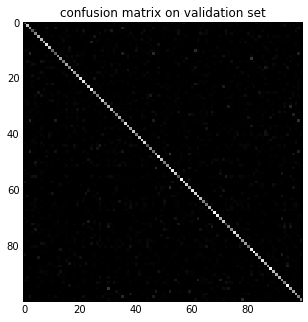

In [7]:
'''plot confusion matrix'''
confusion_mat = np.zeros((num_class,num_class))
for i in range(num_class):
    idx=np.nonzero(train_val_img_labels==i)[0]
    pred_label_ = pred_labels_val[idx]
    confusion_mat[i,:] = np.float64(np.bincount(pred_label_,minlength=num_class))/np.float64(len(idx))    
plt.figure()
plt.title('confusion matrix on validation set')
plt.imshow(confusion_mat)

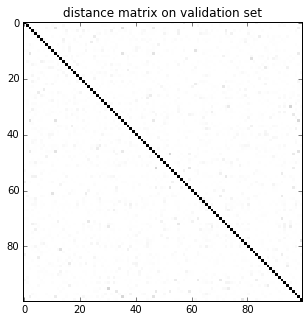

In [10]:
dist_mat = 1.0 - confusion_mat
'''set diagonal elements to 0'''
dist_mat[range(num_class),range(num_class)]=0
dist_mat = 0.5 * (dist_mat + dist_mat.T)
plt.figure()
plt.title('distance matrix on validation set')
plt.imshow(dist_mat)

[-0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1
 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1
 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1
 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1
 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1
 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1
 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1]


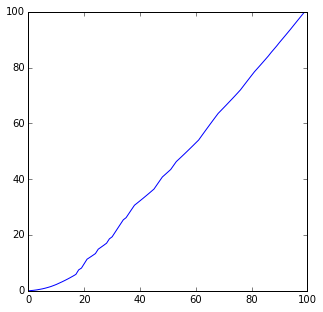

In [11]:
'''Laplacian eigenmap dimensionality reduction
construct adjacency graph W (symmetric) using k-NN'''
W=np.zeros((num_class,num_class))

''' 9 clusteres'''
k_nn, t, dim = 5, 0.9, 4

for i in range(num_class):
    idx=np.argsort(dist_mat[i,:])[1:k_nn+1]
    W[i,idx]=np.exp(-dist_mat[i,idx] / t)
    W[idx,i]=W[i,idx]
D=np.zeros(W.shape)
for i in range(num_class):
    D[i,i]=np.sum(W[i,:])
L=D-W
eig_val,eig_vec=scipy.linalg.eig(L,D)
ftr=eig_vec[:,1:dim+1]
print eig_vec[:,0] # the 1st eigenvector should be all ones
eigval_cumsum = np.cumsum(np.real(eig_val))
plt.plot(eigval_cumsum)

In [13]:
'''affinity propagation clustering'''
if 1: 
    '''9 clusters'''
    affinity_propagation_cluster = AffinityPropagation(damping=0.75, max_iter=15000, convergence_iter=50, copy=True) 
    
    cluster_labels = affinity_propagation_cluster.fit_predict(ftr)
    unique_cluster_label = np.unique(cluster_labels)
    n_cluster = unique_cluster_label.shape[0]
    cluster_members=[None]*n_cluster

    print '%d clusters' % n_cluster
    for i in range(n_cluster):
        idx = np.nonzero(cluster_labels == unique_cluster_label[i])[0]
        cluster_members[i]=list(idx)
        print 'cluster %d size %d ' % (i, len(idx))
        for j in range(len(idx)):
            print '%s,' % label_names[idx[j]],
        print ' '

9 clusters
cluster 0 size 6 
bed, chair, couch, table, television, wardrobe,  
cluster 1 size 11 
bottle, bowl, can, clock, cup, keyboard, lamp, plate, rocket, skyscraper, telephone,  
cluster 2 size 16 
aquarium_fish, bee, beetle, butterfly, caterpillar, cockroach, crab, lizard, lobster, shark, snail, snake, spider, sunflower, trout, worm,  
cluster 3 size 7 
baby, bicycle, boy, chimpanzee, girl, man, woman,  
cluster 4 size 6 
forest, maple_tree, oak_tree, palm_tree, pine_tree, willow_tree,  
cluster 5 size 8 
apple, orange, orchid, pear, poppy, rose, sweet_pepper, tulip,  
cluster 6 size 30 
bear, beaver, camel, cattle, crocodile, dinosaur, dolphin, elephant, flatfish, fox, hamster, kangaroo, leopard, lion, mouse, mushroom, otter, porcupine, possum, rabbit, raccoon, ray, seal, shrew, skunk, squirrel, tiger, turtle, whale, wolf,  
cluster 7 size 5 
cloud, mountain, plain, road, sea,  
cluster 8 size 11 
bridge, bus, castle, house, lawn_mower, motorcycle, pickup_truck, streetcar, tank

In [14]:
''' compute a  histogram of the percentage of images 
that are classified as a label in the same cluster of its groundtruth label
'''
def plot_cluster_coverage(num_class, cluster_mbs,confusion_mat):
    cluster_coverage=np.zeros((num_class))
    for i in range(len(cluster_mbs)):
        for j in range(len(cluster_mbs[i])):
            class_id=cluster_mbs[i][j]
            cluster_coverage[class_id]=np.sum(confusion_mat[class_id,cluster_mbs[i]])
    n, bins, patches=plt.hist(cluster_coverage,bins=20)
    
def read_text(fn):
    text=[]
    f=open(fn)
    for line in f:
        text+=[line]
    f.close()
    return text

def write_text(fn,text):
    f=open(fn,'w')
    f.writelines(text)
    f.close()
    
def find_layer_id(lay_names,lay_name):
    for i in range(len(lay_names)):
        if lay_names[i]==lay_name:
            return i
    return -1

'''replace layer names with customized names'''
def customize_layer_name(text,lay_nams,lin_nums,insert_prefix, insert_suffix, lin_num_offset=0):
    for i in range(len(lay_nams)):
        lin_nums_=lin_nums[i]
        for lin_num in lin_nums_:
            lin_num = lin_num - lin_num_offset
            if lin_num > len(text):
                continue
            id=text[lin_num].find(lay_nams[i])
            if id<0:
                print '%s is not found in: %s' % (lay_nams[i],text[lin_num])
                continue
            text[lin_num]=text[lin_num][:id]+insert_prefix+lay_nams[i]\
            +insert_suffix+text[lin_num][id+len(lay_nams[i]):]
    return text

def set_lr_decay_mult(text, lr_mult, decay_mult):
    for i in range(len(text)):
        id=text[i].find('lr_mult')
        if id>=0:
            text[i]=text[i][:id]+'lr_mult: %3.2f\n'%lr_mult
        id=text[i].find('decay_mult')
        if id>=0:
            text[i]=text[i][:id]+'decay_mult: %3.2f\n'%decay_mult
    return text


In [15]:
version ='v0.0'
example_dir = caffe_root + 'examples/cifar100/'
print 'example_dir',example_dir
if not os.path.exists(example_dir): 
    os.mkdir(example_dir)

save_dir = model_dir + '%dclusters/'%n_cluster 
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
save_dir += '%dclusters_%s/'%(n_cluster,version)
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
print 'save_dir',save_dir
print 'n_cluster',n_cluster

example_dir /home/zyan3/proj/caffe_private_hdcnn/examples/cifar100/
save_dir /home/zyan3/proj/caffe_private_hdcnn/models/cifar100_NIN_float_crop_v2/9clusters/9clusters_v0.0/
n_cluster 9


total_member 389


(array([ 1.,  0.,  2.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  2.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([ 17.  ,  20.15,  23.3 ,  26.45,  29.6 ,  32.75,  35.9 ,  39.05,
         42.2 ,  45.35,  48.5 ,  51.65,  54.8 ,  57.95,  61.1 ,  64.25,
         67.4 ,  70.55,  73.7 ,  76.85,  80.  ]),
 <a list of 20 Patch objects>)

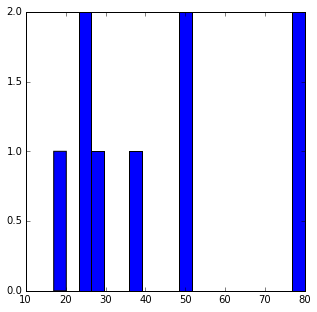

In [16]:
''' Adding extra classes to each branch to compensate for coarse misclassification at gating part
For each branch, sort all classes out of branch based on likelihood that they're misclassified into the branch
Take the top ones and also limit the total number of classes within each branch
'''

exp_cluster_members=[None]*n_cluster
if 1:
    all_mb=range(num_class)
    # for 9 clusters v0.0
    gamma=5.0
    score_thres=1.0/(gamma*n_cluster)
    
    
    max_exp_clu_size=80
    extra_cluster_members=[None]*n_cluster

    for i in range(n_cluster):
        non_member = np.asarray(np.setdiff1d(range(num_class),cluster_members[i]))
    #     print non_member.shape
        score=np.zeros((non_member.shape[0]))
        for j in range(non_member.shape[0]):
            idx=np.nonzero(train_val_img_labels==non_member[j])[0]
            lc_prob=val_prob[idx,:][:,cluster_members[i]]
            score[j]=np.mean(np.sum(lc_prob,axis=1))
        score_sorted=np.sort(score)[::-1]
        idx_sort=np.argsort(score)[::-1]
        idx2=np.nonzero(score_sorted>=score_thres)[0]
        if len(idx2)+len(cluster_members[i])> max_exp_clu_size:
            idx2=idx2[:(max_exp_clu_size-len(cluster_members[i]))]
        extra_cluster_members[i]=[non_member[idx_sort[id]] for id in idx2]
        exp_cluster_members[i]=cluster_members[i]+extra_cluster_members[i]
        assert len(exp_cluster_members[i])==np.unique(np.asarray(exp_cluster_members[i])).shape[0]
else:
    '''disjoint coarse category'''
    for i in range(n_cluster):
        exp_cluster_members[i]=cluster_members[i]
        
total_member=sum([len(cluster) for cluster in exp_cluster_members])
print 'total_member %d' % total_member
plt.hist([len(cluster) for cluster in exp_cluster_members],bins=20)

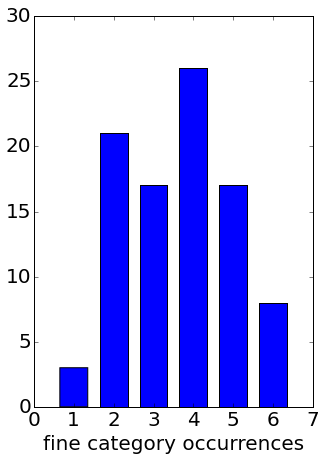

In [17]:
plt.rcParams['figure.figsize'] = (5, 7)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
fine_category_occurrence=np.zeros((num_class),dtype=np.int32)
for i, exp_cluster_member in enumerate(exp_cluster_members):
    for j in range(len(exp_cluster_member)):
        fine_category_occurrence[exp_cluster_member[j]]+=1
n, bins, patches=plt.hist(fine_category_occurrence,bins=np.arange(0,np.max(fine_category_occurrence),1)+0.5,rwidth=0.7,histtype='bar')
# plt.ylabel('fine category occurrence')
plt.xlabel('fine category occurrences',fontsize=20)
# plt.ylabel('count',fontsize=28)
plt.tick_params(axis='both', which='major', labelsize=20)

In [18]:
print num_class
fine2multicoarse=[None]*num_class
for i in range(num_class):
    fine2multicoarse[i]=[]
for i in range(len(exp_cluster_members)):
    for j in range(len(exp_cluster_members[i])):
        fine2multicoarse[exp_cluster_members[i][j]] += [i]

100


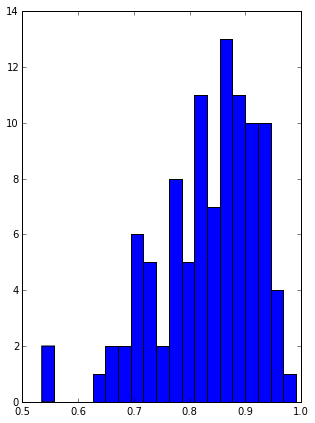

In [19]:
plot_cluster_coverage(num_class,cluster_members,confusion_mat)

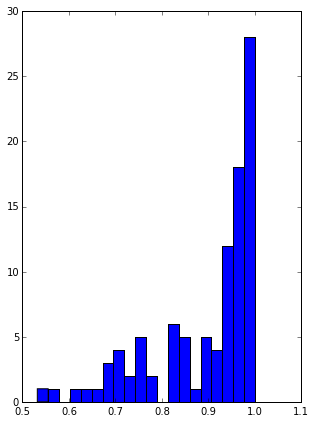

In [20]:
plot_cluster_coverage(num_class,exp_cluster_members,confusion_mat)

In [22]:
label_2_clusterid = np.zeros((class_num))
for i in range(n_cluster):
    print 'cluster %d size %d' %(i, len(cluster_members[i]))
    for j in range(len(cluster_members[i])):
        label_2_clusterid[cluster_members[i][j]] = i

label_2_clusterid_file = caffe_root + 'data/cifar100/label_2_clusterid_%dclusters_%s_NIN.txt' % (n_cluster,version)

f=open(label_2_clusterid_file,'w')
for i in range(class_num):
    f.write('%d\n' % label_2_clusterid[i])
f.close()

cluster 0 size 6
cluster 1 size 11
cluster 2 size 16
cluster 3 size 7
cluster 4 size 6
cluster 5 size 8
cluster 6 size 30
cluster 7 size 5
cluster 8 size 11


In [23]:
'''
read 100-class probabilities for testing images from leveldb
'''
test_poolg_db = leveldb.LevelDB(caffe_root + 'examples/cifar100/cifar100_NIN_float_crop_v2_test_poolg_leveldb')
num_test=10000
test_prob=np.zeros((num_test,num_class))

for i in range(num_test):
    key='%d'%i
    str_data=test_poolg_db.Get(key)
    datum = caffe_pb2.Datum()
    datum.ParseFromString(str_data)    
    for j in range(num_class):
        test_prob[i,j]=datum.float_data[j]
test_prob=softmax(test_prob)
test_pred_lbs=np.argmax(test_prob,axis=1)

test_img_list = caffe_root + 'data/cifar100/test.txt'
test_img_names,test_img_labels=read_val_image_list(test_img_list)

compute softmax probabilities
num 10000 dim 100
10000 validation images 


In [24]:
'''calculate coarse category classification accuracy when classification layer 
(FC layer) has one neuron for each fine category '''
'''
read 1000-class probabilities of 50K test set images
'''
fine_accu=sum([1 if gt==pred else 0 for (gt,pred) in zip(test_img_labels, test_pred_lbs)])/float(len(test_pred_lbs))
coarse_accu=sum([1 if label_2_clusterid[gt]==label_2_clusterid[pred] else 0 for (gt,pred) in zip(test_img_labels,test_pred_lbs)])/float(len(test_pred_lbs))
print 'fine classification accuracy %4.3f' % fine_accu
print 'coarse classification accuracy %4.3f' % coarse_accu

fine classification accuracy 0.625
coarse classification accuracy 0.832


In [25]:
'''for each cluster, write down the labels it owns'''
local_data_dir = 'data/cifar100/cluster_confusion_mat_%dclusters_NIN/' % (n_cluster)
data_dir = caffe_root+local_data_dir
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

local_data_dir=local_data_dir+'%s/' % version
data_dir=caffe_root+local_data_dir
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
    
for i in range(n_cluster):
    f = open(data_dir + 'cluster%02d_labels.txt' % i,'w')
    for j in range(len(cluster_members[i])):
        f.write('%d\n' % cluster_members[i][j])
    f.close()
    
'''For each expanded cluster, prepare a training set with image's label remapped '''
for i in range(n_cluster):
    f=open(data_dir + 'exp_cluster%02d_label_map.txt' % i,'w')
    for j in range(len(exp_cluster_members[i])):
        f.write('%d %d\n' % (exp_cluster_members[i][j],j))
    f.close()    

In [26]:
train_img_list= caffe_root + 'data/cifar100/train.txt'
test_img_list = caffe_root + 'data/cifar100/test.txt'
train_img_names,train_img_labels=read_val_image_list(train_img_list)
test_img_names,test_img_labels=read_val_image_list(test_img_list)
train_img_labels,test_img_labels=np.asarray(train_img_labels),np.asarray(test_img_labels)

50000 validation images 
10000 validation images 


In [27]:
'''for each cluster, write down a selective file list'''
for i in range(n_cluster):
    print '%d out of %d clusters' % (i+1,n_cluster)
    name_label_list=[]
    f=open(data_dir+'selective_list_cluster%02d_train.txt'%i,'w')
    for j in range(train_img_labels.shape[0]):
        tr_img_label = train_img_labels[j]
        count = exp_cluster_members[i].count(tr_img_label)
        if count > 1:
            print 'error count ',count
        if count == 1:
            index=exp_cluster_members[i].index(tr_img_label)
            name_label_list += [(train_img_names[j],index)]
#     print name_label_list[0],name_label_list[1]
    shuffle(name_label_list)
#     print name_label_list[0],name_label_list[1]
    
    for j in range(len(name_label_list)):
        f.write('%s %d\n'%(name_label_list[j][0],name_label_list[j][1]))
    f.close()
    print 'cluster:%02d. %d training images' %(i, len(name_label_list))
    
    
    name_label_list=[]
    f=open(data_dir+'selective_list_cluster%02d_test.txt'%i,'w')
    for j in range(test_img_labels.shape[0]):
        test_img_label=test_img_labels[j]
        count = exp_cluster_members[i].count(test_img_label)
        if count > 1:
            print 'error count',count
        if count == 1:
            index=exp_cluster_members[i].index(test_img_label)
            name_label_list += [(test_img_names[j],index)]
    shuffle(name_label_list)
    for j in range(len(name_label_list)):
        f.write('%s %d\n'%(name_label_list[j][0],name_label_list[j][1]))    
    f.close()
    print 'cluster:%02d. %d validation images' %(i, len(name_label_list))
    

1 out of 9 clusters
cluster:00. 12500 training images
cluster:00. 2500 validation images
2 out of 9 clusters
cluster:01. 25500 training images
cluster:01. 5100 validation images
3 out of 9 clusters
cluster:02. 40000 training images
cluster:02. 8000 validation images
4 out of 9 clusters
cluster:03. 18000 training images
cluster:03. 3600 validation images
5 out of 9 clusters
cluster:04. 12000 training images
cluster:04. 2400 validation images
6 out of 9 clusters
cluster:05. 13500 training images
cluster:05. 2700 validation images
7 out of 9 clusters
cluster:06. 40000 training images
cluster:06. 8000 validation images
8 out of 9 clusters
cluster:07. 8500 training images
cluster:07. 1700 validation images
9 out of 9 clusters
cluster:08. 24500 training images
cluster:08. 4900 validation images


In [28]:
net_def_fn =model_dir + 'train_test.prototxt'
net_def = read_text(net_def_fn)

In [29]:
lay_nams=['conv1', 'cccp1','relu1','cccp2','relu2','pool1','drop1',
          'conv2', 'cccp3','relu3','cccp4','relu4','pool2','drop2',
          'conv3','cccp5','relu5','cccp6','relu6','poolg']

In [30]:
lin_nums=[]
for lay_nam in lay_nams:
    lin_nums_=[]
    for i in range(len(net_def)):
        id=net_def[i].find('"'+lay_nam+'"')
        if id>=0:
            lin_nums_+=[i]
    lin_nums += [lin_nums_]

In [34]:
n_kmean_cluster={}
n_seg={}

'''cifar100_NIN_float_crop_v2'''
n_kmean_cluster['conv2']=64
n_seg['conv2']=1200

n_kmean_cluster['cccp3']=64
n_seg['cccp3']=96

n_kmean_cluster['cccp4']=64
n_seg['cccp4']=96

n_kmean_cluster['conv3']=64
n_seg['conv3']=192*3

n_kmean_cluster['cccp5']=64
n_seg['cccp5']=96

In [40]:
train_source_line,test_source_line=15,35
data_lay_rang = [0,43]
mid_lay_rang=[data_lay_rang[1],418]
share_lay_last_nm='drop1'
share_lay_last_id=find_layer_id(lay_nams,share_lay_last_nm)
cccp6_lay_id=find_layer_id(lay_nams,'cccp6')
print 'share_lay_last_id:%d' % share_lay_last_id
print 'cccp6_lay_id',cccp6_lay_id


net_quantization_kmean_num_cluster_line={}
net_quantization_kmean_num_cluster_line['conv2']=186
net_quantization_kmean_num_cluster_line['cccp3']=221
net_quantization_kmean_num_cluster_line['cccp4']=261
net_quantization_kmean_num_cluster_line['conv3']=323
net_quantization_kmean_num_cluster_line['cccp5']=358

net_cccp6_num_output_line = 386

share_lay_last_id:6
cccp6_lay_id 17


In [41]:
'''
two-time branch pre-training
train a separate CNN for each cluster 
For each cluster, prepare solver/train_test/deploy prototxt 
'''


'''9 clusters, v0.0, overlapping coarse category'''
max_iter = [8000,15000,25000]

solver_proto=['solver.prototxt',\
              'solver_lr1.prototxt',\
              'solver_lr2.prototxt']

train_test_proto, deploy_proto=\
model_dir + 'train_test.prototxt',\
model_dir + 'deploy.prototxt'

solver_proto_templates = [None]*len(solver_proto)
for i in range(len(solver_proto)):
    solver_proto_templates[i]=[]
    f=open(model_dir + solver_proto[i],'r')
    for line in f:
        solver_proto_templates[i]+=[line]
    f.close()

train_test_proto_template,deploy_proto_template=[],[]
with open(train_test_proto,'r') as f:
    for line in f:
        train_test_proto_template+=[line]

with open(deploy_proto,'r') as f:
    for line in f:
        deploy_proto_template+=[line]
    
solver_proto_net_line,\
solver_proto_test_iter_line,solver_proto_max_iter_line,\
solver_proto_prefix_line=4,8,18,23


for i in range(n_cluster):
    cccp6_num_output_i = len(exp_cluster_members[i])
    net_nm = 'cluster%02d_train_test.prototxt'%\
    (i)
    deploynet_nm = 'cluster%02d_deploy.prototxt'%\
    (i)
    
    for j in range(len(solver_proto)):
        solver_proto_ = copy.deepcopy(solver_proto_templates[j])
        solver_proto_[solver_proto_net_line] = 'net: "%s%s"\n' % (save_dir,net_nm)
    
        solver_proto_[solver_proto_test_iter_line] = 'test_iter: %d\n' % len(exp_cluster_members[i])
        solver_proto_[solver_proto_max_iter_line] = 'max_iter: %d\n' % max_iter[j]
        solver_proto_[solver_proto_prefix_line-1] = 'snapshot: 1000\n'        
        solver_proto_[solver_proto_prefix_line] = \
    'snapshot_prefix: "%scluster%02d"\n' \
    % (save_dir, i)
            
        f=open(save_dir+'cluster%02d_%s' %(i, solver_proto[j]),'w')
        f.writelines(solver_proto_)
        f.close()
    
    train_test_proto_ = copy.deepcopy(train_test_proto_template)
    train_test_proto_[train_source_line+3] = \
    '\tselective_list: "%sselective_list_cluster%02d_train.txt"\n'%(local_data_dir,i)
    
    train_test_proto_[test_source_line+3] = \
    '\tselective_list: "%sselective_list_cluster%02d_test.txt"\n'%(local_data_dir,i)
    
    customize_layer_name(train_test_proto_,lay_nams[share_lay_last_id+1:],lin_nums[share_lay_last_id+1:],\
                         'cluster%02d_'%i, '', lin_num_offset=0)
    customize_layer_name(train_test_proto_,[lay_nams[cccp6_lay_id]],[lin_nums[cccp6_lay_id]],\
                         '', '_compact', lin_num_offset=0)
    
    train_test_proto_[:lin_nums[share_lay_last_id+1][0]-1]=\
    set_lr_decay_mult(train_test_proto_[:lin_nums[share_lay_last_id+1][0]-1], 0, 0)
    train_test_proto_[net_cccp6_num_output_line] = \
    '\t\t\t\tnum_output: %d\n' % cccp6_num_output_i
    
    for layer_name in ['conv2','cccp3','cccp4','conv3','cccp5']:
        train_test_proto_[net_quantization_kmean_num_cluster_line[layer_name]]='\t\tquantization_kmean_num_cluster: %d\n'\
        %(n_kmean_cluster[layer_name])
        train_test_proto_[net_quantization_kmean_num_cluster_line[layer_name]+1]='\t\tquantization_num_segment: %d\n'\
        %(n_seg[layer_name])        
        train_test_proto_[net_quantization_kmean_num_cluster_line[layer_name]+2]=\
        '\t\tquantization_kmean_cluster_centers_file: "%s%dclusters/%dclusters_%s/iter_25000/cluster%02d_%s_%d_%d_kmean_cluster_centers.binaryproto"\n'%\
        (local_model_dir,n_cluster,n_cluster, version, i,layer_name,n_kmean_cluster[layer_name],n_seg[layer_name])
        train_test_proto_[net_quantization_kmean_num_cluster_line[layer_name]+3]=\
        '\t\tquantization_kmean_cluster_indices_file: "%s%dclusters/%dclusters_%s/iter_25000/cluster%02d_%s_%d_%d_kmean_cluster_indices.binaryproto"\n'%\
        (local_model_dir,n_cluster,n_cluster, version, i, layer_name, n_kmean_cluster[layer_name],n_seg[layer_name])
        train_test_proto_[net_quantization_kmean_num_cluster_line[layer_name]+5]='\tconserve_gpu_memory_test: false\n'
        train_test_proto_[net_quantization_kmean_num_cluster_line[layer_name]+6]='\tparameter_compress: false\n'        
    
    with open(save_dir+net_nm,'w') as f:
        f.writelines(train_test_proto_)
     
    deploy_proto_ = copy.deepcopy(deploy_proto_template)
    customize_layer_name(deploy_proto_,lay_nams[share_lay_last_id+1:],lin_nums[share_lay_last_id+1:],\
                         'cluster%02d_'%i, '', lin_num_offset=0)
    customize_layer_name(deploy_proto_,[lay_nams[cccp6_lay_id]],[lin_nums[cccp6_lay_id]],\
                         '', '_compact', lin_num_offset=0)     
    deploy_proto_[net_cccp6_num_output_line] = \
    '\t\t\t\tnum_output: %d\n' % cccp6_num_output_i
    with open(save_dir+deploynet_nm,'w') as f:
        f.writelines(deploy_proto_)

In [33]:
'''
prepare final HD-CNN solver prototxt files
'''
solver_proto=['solver.prototxt','solver_lr1.prototxt']

solver_proto_output=['hdcnn_solver.prototxt','hdcnn_solver_lr1.prototxt']

solver_proto_templates = [None]*len(solver_proto)
for i in range(len(solver_proto)):
    solver_proto_templates[i]=[]
    with open(model_dir + solver_proto[i],'r') as f:
        for line in f:
            solver_proto_templates[i]+=[line]
            
solver_proto_net_line, solver_proto_test_iter_line, solver_proto_baselr_line, \
solver_proto_max_iter_line, solver_proto_prefix_line=4,8,12,18,23

base_lr = [1e-3,1e-4]
hdcnn_max_iter = [10000,20000]

for j in range(len(solver_proto)):
    solver_proto_ = copy.deepcopy(solver_proto_templates[j])
    solver_proto_[solver_proto_net_line] = \
    'net: "%shdcnn_train_test.prototxt"\n'\
    % (save_dir)
    solver_proto_[solver_proto_test_iter_line] = \
    'test_iter: 200\n'
    
    solver_proto_[solver_proto_baselr_line] = 'base_lr: %7.6f\n' % base_lr[j]
    solver_proto_[solver_proto_max_iter_line] = 'max_iter: %d\n' % hdcnn_max_iter[j]
    solver_proto_[solver_proto_prefix_line] = \
'snapshot_prefix: "%shdcnn"\n' \
% (save_dir)


    solver_fn=save_dir+solver_proto_output[j]
    print solver_fn
    with open(solver_fn,'w') as f:
        f.writelines(solver_proto_)


/home/zyan3/proj/caffe_private_hdcnn/models/cifar100_NIN_float_crop_v2/9clusters/9clusters_v0.0/hdcnn_solver.prototxt
/home/zyan3/proj/caffe_private_hdcnn/models/cifar100_NIN_float_crop_v2/9clusters/9clusters_v0.0/hdcnn_solver_lr1.prototxt


In [36]:
iter_num = 25000
per_cluster_tr_batch_size = 20
train_batch_size_lin_num, test_batch_size_lin_num = 16, 36

hdcnn_def=[]
'''write data layer part'''
for lin_num in range(data_lay_rang[0],data_lay_rang[1]):
    hdcnn_def += [net_def[lin_num]]

hdcnn_def[train_batch_size_lin_num] = '\tbatch_size: %d\n' % (per_cluster_tr_batch_size * n_cluster)
hdcnn_def[test_batch_size_lin_num] = '\tbatch_size: 50\n'

'''write gating part'''
for lin_num in range(mid_lay_rang[0],mid_lay_rang[1]):
    hdcnn_def += [net_def[lin_num]]
    
for layer_name in ['conv2','cccp3','cccp4','conv3','cccp5']:
    quantization_kmean_num_cluster_line=net_quantization_kmean_num_cluster_line[layer_name]
    hdcnn_def[quantization_kmean_num_cluster_line]='\t\tquantization_kmean_num_cluster: %d\n'\
    %(n_kmean_cluster[layer_name])
    hdcnn_def[quantization_kmean_num_cluster_line+1]='\t\tquantization_num_segment: %d\n'\
    %(n_seg[layer_name])        
    hdcnn_def[quantization_kmean_num_cluster_line+2]=\
    '\t\tquantization_kmean_cluster_centers_file: "%s%s_%d_%d_kmean_cluster_centers.binaryproto"\n'%\
    (local_model_dir,layer_name,n_kmean_cluster[layer_name],n_seg[layer_name])
    hdcnn_def[quantization_kmean_num_cluster_line+3]=\
    '\t\tquantization_kmean_cluster_indices_file: "%s%s_%d_%d_kmean_cluster_indices.binaryproto"\n'%\
    (local_model_dir, layer_name, n_kmean_cluster[layer_name],n_seg[layer_name])
    hdcnn_def[quantization_kmean_num_cluster_line+5]='\tconserve_gpu_memory_test: false\n'
    hdcnn_def[quantization_kmean_num_cluster_line+6]='\tparameter_compress: false\n'   
        
'''write SOFTMAX fine-classification layer in the gating part'''
hdcnn_def +=['layer {\n',\
                        '\tname: "fine_branch_prob"\n',\
                        '\ttype: "Softmax"\n',\
                        '\tbottom: "poolg"\n',\
                        '\ttop: "fine_branch_prob"\n',\
                        '}\n']
# '''write fine2coarse classification layer in the gating part'''
# hdcnn_def +=['layer {\n',\
#                         '\tname: "coarse_branch_prob"\n',\
#                         '\ttype: "Fine2CoarseProb"\n',\
#                         '\tbottom: "fine_branch_prob"\n',\
#                         '\ttop: "coarse_branch_prob"\n'\
#                         '\tfine2coarse_prob_layer_param{\n',\
#                         '\t\tnum_coarse: %d\n' % n_cluster]
# for i in range(label_2_clusterid.shape[0]):
#     hdcnn_def += ['\t\tfine2coarse: %d\n'%label_2_clusterid[i]]
# hdcnn_def += ['\t}\n',\
#                          '}\n']

'''write fine2multicoarse classification layer in the gating part'''
hdcnn_def +=['layer {\n',\
                        '\tname: "coarse_branch_prob"\n',\
                        '\ttype: "Fine2MultiCoarseProb"\n',\
                        '\tbottom: "fine_branch_prob"\n',\
                        '\ttop: "coarse_branch_prob"\n'\
                        '\tfine2multicoarse_prob_layer_param{\n',\
                        '\t\tnum_coarse: %d\n' % n_cluster]
for i in range(num_class):
    hdcnn_def += ['\t\tfine2multicoarse_param{\n']
    for j in range(len(fine2multicoarse[i])):
        hdcnn_def+= ['\t\t\tcoarse_id: %d\n' % fine2multicoarse[i][j]]
    hdcnn_def +=['\t\t}\n']
hdcnn_def += ['\t}\n',\
                         '}\n']


'''write independent layers in branching parts'''
for i in range(n_cluster):
    br_def=[]
    lin_num_offset=lin_nums[share_lay_last_id+1][0]-2
    
    for lin_num in range(lin_nums[share_lay_last_id+1][0]-2,mid_lay_rang[1]):
        br_def+=[net_def[lin_num]]

    br_lay_nams=[lay_nams[id] for id in range(share_lay_last_id+1,len(lay_nams))]
    br_lin_nums=[lin_nums[id] for id in range(share_lay_last_id+1,len(lay_nams))]
    
    customize_layer_name(br_def,br_lay_nams,br_lin_nums,'cluster%02d_'%i,\
                                '',lin_num_offset)
    customize_layer_name(br_def,[lay_nams[cccp6_lay_id]],[lin_nums[cccp6_lay_id]],'',\
                                '_compact',lin_num_offset)
    br_def[net_cccp6_num_output_line-br_lin_nums[0][0]+2]='\t\tnum_output: %d\n' % len(exp_cluster_members[i])


    br_def += ['layer {\n',\
              '\tname: "cluster%02d_prob_compact"\n'%i,\
              '\ttype: "Softmax"\n',\
              '\tbottom: "cluster%02d_poolg"\n'%i,\
              '\ttop: "cluster%02d_prob_compact"\n'%i,\
              '}\n']
    
    for layer_name in ['conv2','cccp3','cccp4','conv3','cccp5']:
        quantization_kmean_num_cluster_line=net_quantization_kmean_num_cluster_line[layer_name]-lin_num_offset
        br_def[quantization_kmean_num_cluster_line]='\t\tquantization_kmean_num_cluster: %d\n'\
        %(n_kmean_cluster[layer_name])
        br_def[quantization_kmean_num_cluster_line+1]='\t\tquantization_num_segment: %d\n'\
        %(n_seg[layer_name])        
        br_def[quantization_kmean_num_cluster_line+2]=\
        '\t\tquantization_kmean_cluster_centers_file: "%s%dclusters/%dclusters_%s/iter_%d/cluster%02d_%s_%d_%d_kmean_cluster_centers.binaryproto"\n'%\
        (local_model_dir,n_cluster,n_cluster, version, iter_num, i,layer_name,n_kmean_cluster[layer_name],n_seg[layer_name])
        br_def[quantization_kmean_num_cluster_line+3]=\
        '\t\tquantization_kmean_cluster_indices_file: "%s%dclusters/%dclusters_%s/iter_%d/cluster%02d_%s_%d_%d_kmean_cluster_indices.binaryproto"\n'%\
        (local_model_dir,n_cluster,n_cluster, version, iter_num, i, layer_name, n_kmean_cluster[layer_name],n_seg[layer_name])
        br_def[quantization_kmean_num_cluster_line+5]='\tconserve_gpu_memory_test: false\n'
        br_def[quantization_kmean_num_cluster_line+6]='\tparameter_compress: false\n'        
    

    for br_def_lin in br_def:
        hdcnn_def += [br_def_lin]

hdcnn_def += ['layer {\n',\
                        '\tname: "compact_probabilistic_average_prob"\n',\
                        '\ttype: "CompactProbabilisticAverageProb"\n']
for i in range(n_cluster):
    hdcnn_def+= ['\tbottom: "cluster%02d_prob_compact"\n'%i]
hdcnn_def+=['\tbottom: "coarse_branch_prob"\n',\
                       '\ttop: "compact_probabilistic_average_prob"\n',\
                       '\tcompact_probabilistic_average_prob_layer_param{\n',\
                       '\t\tnum_class:%d\n'%num_class]
for i in range(n_cluster):
    hdcnn_def+=['\t\tcompact_classify_layer_param{\n']
    for j in range(len(exp_cluster_members[i])):
        hdcnn_def+=['\t\t\tclass_id:%d\n'%exp_cluster_members[i][j]]
    hdcnn_def+=['\t\t}\n']
hdcnn_def+=['\t}\n',\
                       '}\n']

hdcnn_def += ['layer {\n',\
                        '\tname: "loss"\n',\
                        '\ttype: "MultinomialLogisticSparsityLoss"\n',\
                        '\tbottom: "compact_probabilistic_average_prob"\n',\
                        '\tbottom: "label"\n',\
                        '\tbottom: "coarse_branch_prob"\n',\
                        '\ttop: "loss"\n',\
                        '\tmultinomial_logistic_sparsity_loss_param{\n',
                        '\t\tsparsity_lamda: 5\n']

for i in range(n_cluster):
    hdcnn_def += ['\t\ttarget_sparsity: %4.3f\n'% (float(len(exp_cluster_members[i])) / float(total_member))]

hdcnn_def+=['\t}\n',\
                      '}\n']
hdcnn_def+=['layer {\n',\
                       '\tname: "accuracy"\n',\
                       '\ttype: "Accuracy"\n',\
                       '\tbottom: "compact_probabilistic_average_prob"\n',\
                       '\tbottom: "label"\n',\
                       '\ttop: "accuracy"\n',\
                       '\tinclude {\n',\
                       '\t\tphase: TEST\n',\
                       '\t}\n',\
                       '}\n']

hdcnn_def_fn=save_dir+'hdcnn_train_test.prototxt'
print 'write file:%s'%hdcnn_def_fn
f=open(hdcnn_def_fn,'w')
for ln in hdcnn_def:
    f.write(ln)
f.close()

write file:/home/zyan3/proj/caffe_private_hdcnn/models/cifar100_NIN_float_crop_v2/9clusters/9clusters_v0.0/hdcnn_train_test.prototxt


In [38]:
'''write shell script for finetuning HD-CNN'''

script_fn=example_dir+'finetune_hdcnn_from_NIN_float_crop_v2_%dclusters_%s.sh'%(n_cluster,version)
print 'script: %s' % script_fn 
with open(script_fn,'w') as f:
    f.write('#!/bin/bash\n')
    f.write('TOOLS=build/tools\n')
    f.write('GLOG_logtostderr=1 $TOOLS/finetune_net_match --match_mode=EXACT_MATCH \\\n')
    f.write('\t--solver=%s%s \\\n'%(save_dir, solver_proto_output[0]))
    f.write('\t%scifar100_NIN_float_crop_v2_iter_130000.caffemodel \\\n' % model_dir)
    for i in range(n_cluster):
        f.write('\t%scluster%02d_iter_25000.caffemodel \\\n'%(save_dir,i))

    f.write('\n')

script: /home/zyan3/proj/caffe_private_hdcnn/examples/cifar100/finetune_hdcnn_from_NIN_float_crop_v2_9clusters_v0.0.sh
